In [10]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy.random as rng

# Multiclass Classification

* The natural extension to binary classification is multiclass classification, where the model has to predict the probability of more than two classes. For example,

![alt text](figures/multiclass_classification.png)

* Before we implement this with a neural network, we need to take care of three things: representing the classes, the output of the neural network, and the loss function.

## Class Representation: One-hot Encoding

* Let's load the dataset representing the previous figure and examine how the outputs are coded:

In [11]:
d = np.load('data/multiclass_classification.npz')
X, y = d['X'], d['y']
print(y[:5]) # print classes of first five points

[[3]
 [0]
 [5]
 [2]
 [1]]


* So the classes are represented with a number from 0 to 5 (6 classes)
* But remember: classes have no ordering relationship, class 1 is not "less" than class 5. So we cannot train the network on the dataset as it is
* We need a way to tell the network that classes are not ordered. This is done via _one-hot encoding_: create a binary vector with $N$ entries, and set the bit that corresponds to the class, for example:
    

In [12]:
n_classes = 5

theclass = 3
one_hot_encoded = np.zeros(n_classes)
one_hot_encoded[theclass] = 1
print(one_hot_encoded)

theclass = 0
one_hot_encoded = np.zeros(n_classes)
one_hot_encoded[theclass] = 1
print(one_hot_encoded)

[0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0.]


* And here is how to convert the outputs in the datset into one-hot encoded values:

In [13]:
# get number of classes in the dataset
n_classes = np.max(y) + 1

# allocate storage
Y = np.zeros((y.shape[0], n_classes))

# set bits
Y[np.arange(y.shape[0]), y[:,0]] = 1

# print first few entries
print(Y[:5,:])

[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## Network Output: Softmax

* Great, now the each output is a binary vector, with one bit set and the rest are zeros
* As with binary classification. The network should output the _probability_ of each class. But how to do this?
* Remember: the probabilities of mutually exclusive events should sum to one (a point cannot be in class 0 and 3 simultanously)
* Also remember: each probability should be between 0.0 and 1.0

First, consider the $\text{hardmax}$ function, which takes a vector of numbers and returns a corresponding bit vector with one set in the position of the maximum element in the input vector.


In [14]:
# sample input vector
z = [1, 2, 3, 0, -1]
ix = np.argmax(z)
r = np.zeros(len(z))
r[ix] = 1
print(r)

[0. 0. 1. 0. 0.]


* Neural networks cannot implement such function because it is not differentiable
* Instead, we use a softer version, called _softmax_:
$$\text{softmax}(z_{1},...,z_{n})=\left[\frac{e^{z_{1}}}{\sum e^{z_{i}}},...,\frac{e^{z_{n}}}{\sum e^{z_{i}}}\right]$$
* Here, $z_i$ is a continuous real number that can be negative, positive or zero. 
* Softmax takes a vector of such numbers and outputs a corresponding vector that (a) sums to 1.0 and (b) where each element is between 0 and 1.

In [15]:
z = [1, 2, 3, 0, -1]
smax = np.exp(z) / np.sum(np.exp(z))
print(smax)
print(np.sum(smax))

[0.08612854 0.23412166 0.63640865 0.03168492 0.01165623]
1.0


* Notice how the greatest element gets assigned the highest probability and that the sum of elements is 1.0

## Loss Function: Categorical Cross Entropy

* The final piece of the puzzle is the loss function used to train the network
* For multiclass classification, the loss is the generalization of binary cross entropy:

$$\mathcal{L}(\boldsymbol{\pi}_{i},\boldsymbol{y}_{i})=-\sum_{j}y_{i}^{j}log(\pi_{i}^{j})$$

* Here, $\boldsymbol{\pi}_{i}$ is a vector of class probabilities (output of softmax) and $\boldsymbol{y}_{i}$ is the one-hot encoded class label.

* The model gets rewarded when it assigns a high probability to the true class.

* You can check that this loss reduces to binary cross entropy when there are two classes.

## Neural Network Implementation

* Time to put things together and implement a classifier that predicts the classes of points in the dataset.

In [16]:
# try varying the number of hidden units
n_hidden = 10
eta = 1.0

# read data
data = np.load('data/multiclass_classification.npz')
X, y = data['X'], data['y']

# convert to one-hot-encoding
n_classes = np.max(y) + 1
Y = np.zeros((y.shape[0], n_classes))
Y[np.arange(y.shape[0]), y[:,0]] = 1

# move data to tensorflow space
X = tf.convert_to_tensor(X, dtype=tf.float32)
Y = tf.convert_to_tensor(Y, dtype=tf.float32)

# randomly initialize model parameters
# notice how we now output n_classes instead of one output
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, n_classes), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(n_classes), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 100
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
        pi = tf.nn.softmax(b_output + tf.matmul(hidden_activation, W_hidden_output))
        
        # pi has shape (# data points, n_classes)
        
        # loss
        xe_loss = -tf.reduce_mean( tf.reduce_sum(Y * tf.math.log(pi), axis=1) )
        
        #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
pi = tf.nn.softmax(b_output + tf.matmul(hidden_activation, W_hidden_output))

# report results
pi = pi.numpy()
class_preds = np.argmax(pi, axis=1)
acc = np.mean(class_preds == y[:,0])
print("Accuracy: %0.2f" % acc)
train_pi = pi

Accuracy: 0.90


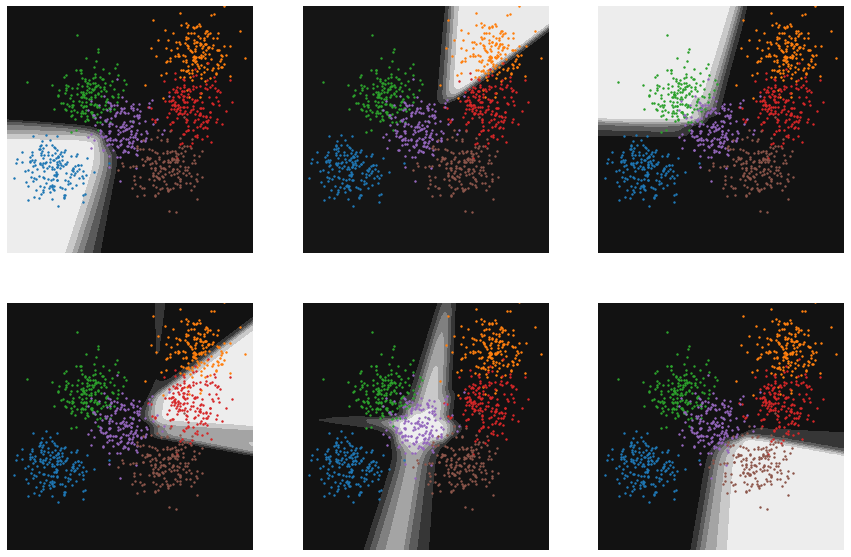

In [21]:
# let's see what the network has learned

# initialize range of input values
K = 100
xs = np.linspace(-15, 15, K)
x1s, x2s = np.meshgrid(xs, xs)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T
Xstar = tf.convert_to_tensor(Xstar, dtype=tf.float32)

# predict
hidden_activation = tf.tanh(b_hidden + tf.matmul(Xstar, W_input_hidden))
pi = tf.nn.softmax(b_output + tf.matmul(hidden_activation, W_hidden_output))

f, axes = plt.subplots(2, int(n_classes/2), figsize=(15, 10), sharex=True, sharey=True)

axes = axes.flatten()

data = np.load('data/multiclass_classification.npz')
X, y = data['X'], data['y']

for i, ax in enumerate(axes):
    pi_class = pi[:, i]
    pi_class = np.reshape(pi_class, (K,K))
    cp = ax.contourf(x1s, x2s, pi_class, cmap=plt.get_cmap('gist_gray'))
    for j in range(n_classes):
        ix = y[:,0] == j
        ax.scatter(X[ix, 0], X[ix, 1], s=2)
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15,15])
    ax.axis('off')
    

## Multiclass Performance Evaluation: Confusion Matrix

* Reporting accuracy is fine but we usually want to know which categories or classes the classifier gets confused about

* For this, we use the confusion matrix. Rows correspond to actual labels and columns correspond to predicted labels. An ideal classifier would have a confusion matrix with 0s in the off-diagonal entries. 

* Let's compute the confusion matrix from our previous classifier:

In [22]:
import sklearn.metrics

preds = np.argmax(train_pi, axis=1)
cm = sklearn.metrics.confusion_matrix(y, preds)
print(cm)

[[166   0   0   0   1   0]
 [  0 127   0  37   3   0]
 [  2   0 162   0   3   0]
 [  0   5   0 158   1   3]
 [  6   0  21   5 130   4]
 [  0   0   0   6   8 152]]


* The classifier correctly predicts 127 instances of class 1, but mispredicts 37 as class 3 and 3 as class 4.

* We can row-normalize the confusion matrix to get percentages. Row-normalization makes the entries in each row sum to 1.0

In [24]:
cm = cm / np.sum(cm, axis=1, keepdims=True)
with np.printoptions(precision=2, suppress=True):
    print(cm)

[[0.99 0.   0.   0.   0.01 0.  ]
 [0.   0.76 0.   0.22 0.02 0.  ]
 [0.01 0.   0.97 0.   0.02 0.  ]
 [0.   0.03 0.   0.95 0.01 0.02]
 [0.04 0.   0.13 0.03 0.78 0.02]
 [0.   0.   0.   0.04 0.05 0.92]]
